In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/DS/US_IMPORT_PROJECT')
!pwd

Mounted at /content/drive
/content/drive/MyDrive/DS/US_IMPORT_PROJECT


In [15]:
#initializing the required libraries
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv("Us_Import(19-23).csv") #imported the data
df = df.melt(id_vars=["Item Name", "Country"],
             var_name="Years",
             value_name="Purchase") #unpivot the data

# cleaning the data, just simple data
df["Purchase"] = df["Purchase"].str.replace(",", "").astype(float).round(2) #removing commas and convert to float
df["Years"] = pd.to_numeric(df["Years"], errors='coerce').fillna(0).astype(int) #year convert to int

In [5]:
df

,Item Name,Country,Years,Purchase
0,live animals,Canada,2023,1808.5
1,live animals,Mexico,2023,1121.9
2,live animals,Rest of world,2023,0.0
3,live animals,World,2023,2930.3
4,"Bovine animals, live",Canada,2023,1297.5
...,...,...,...,...
15045,Oilseeds,Chile,1999,3.6
15046,Oilseeds,India,1999,17.1
15047,Oilseeds,Bulgaria,1999,0.0
15048,Oilseeds,Rest of world,1999,107.6


In [6]:
#the data encoded with label encoder

encoders = {}
for column in df.select_dtypes(include='object').columns:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])
    encoders[column] = encoder

In [7]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,accuracy_score
from sklearn.model_selection import train_test_split

x = df.drop("Purchase", axis=1)
y = df["Purchase"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [8]:
# I choose linear regression model, because the data is time series data, the year may have directly proptional to purchase value

from sklearn.linear_model import LinearRegression
model3 = LinearRegression().fit(x_train,y_train)
y_pred3=model3.predict(x_test)
print("Mean Square Error",mean_squared_error(y_test,y_pred3))
print("Mean Absolute Error",mean_absolute_error(y_test,y_pred3))#priority 2
print("R2_Scroe",r2_score(y_test,y_pred3)) #priority 1

Mean Square Error 2158388.013547591
Mean Absolute Error 789.6327967762056
R2_Scroe 0.1156487387607531


##### The R2_Score is 0.11 which is very poor for linear Regression
##### Here is the Why EDA is very important

In [13]:
cat = ["Item Name", "Country","Years"]
cont = ["Purchase"]

<Axes: >

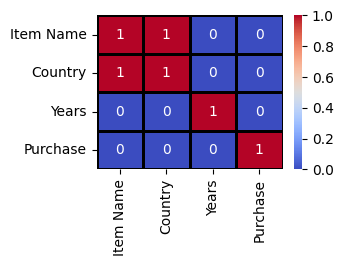

In [17]:
def two_sample(d1, d2):
    m = [0, 0]
    for i in range(31):
        sample1 = d1.sample(frac=0.03)
        sample2 = d2.sample(frac=0.04)
        t_test, p_value = stats.ttest_ind(sample1, sample2, equal_var=False)  # Welch's T-test
        if p_value < 0.04:
            m[1] += 1  # Reject null hypothesis
        else:
            m[0] += 1  # Accept null hypothesis
        if m[0] > m[1]:
            return True  # Accept null hypothesis
        elif m[1] > m[0]:
            return False  # Reject null hypothesis

def chi_square(d1, d2):
    return True if stats.chi2_contingency(pd.crosstab(d1, d2))[1] < 0.075 else False

def annova(df, d1, d2):
    group = df[d2].unique()
    data1 = {i: df[d1][df[d2] == i] for i in group}
    f_value, p_value = stats.f_oneway(*data1.values())
    return p_value >= 0.075  # Return True if connected (null hypothesis not rejected)

# Define categorical and continuous features


# Compare all columns
def compare_columns(df):
    final = {}
    for i in df.columns:
        final[i] = {}
        for j in df.columns:
            result = None
            if i in cont and j in cont:
                result = two_sample(df[i], df[j])
            elif i in cat and j in cat:
                result = chi_square(df[i], df[j])
            elif i in cont and j in cat:
                result = annova(df, i, j)
            elif i in cat and j in cont:
                result = annova(df, j, i)

            if result is not None:
                final[i][j] = 1 if result else 0
    return final

plt.figure(figsize=(3, 2))
# Create the heatmap
sns.heatmap(pd.DataFrame(compare_columns(df)) , annot=True, cmap="coolwarm",linewidths=1, linecolor='black')


*from the above test and these EDA Analysis show that there is no linearity in this data, becuase there is not inter connection one data with target variable, si choose randomforest regressor model

In [18]:
from sklearn.ensemble import RandomForestRegressor
model2 = RandomForestRegressor().fit(x_train,y_train)
y_pred2=model2.predict(x_test)
print("Mean Square Error",mean_squared_error(y_test,y_pred2))
print("Mean Absolute Error",mean_absolute_error(y_test,y_pred2))#priority 2
print("R2_Scroe",r2_score(y_test,y_pred2)) #priority 1

Mean Square Error 104168.9617496746
Mean Absolute Error 119.70890609080841
R2_Scroe 0.9573190954883533


*R2_Score is 0.957 it may lead the over fitting problem, but by hyper tuning it we can reduce it